In [4]:
import glob, os
import numpy as np
import torch
from PIL import Image

## 1. PREPARE THE DATASET

In [5]:
class GateSegDataset(object):
    def __init__(self, img_filenames, mask_filenames, transforms=None):
        self.transforms = transforms
        self.imgs = img_filenames
        self.masks = mask_filenames

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
root = 'WashingtonOBRace'
img_filenames = glob.glob(os.path.join(root, 'img_[0-9]*.png'))
img_filenames = sorted(img_filenames, key=lambda x:int(x[21:-4]))
mask_filenames = glob.glob(os.path.join(root, 'mask_*.png'))
mask_filenames = sorted(mask_filenames, key=lambda x:int(x[22:-4]))

dataset = GateSegDataset(img_filenames, mask_filenames)

In [7]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=360x360 at 0x7F8BA07BA520>,
 {'boxes': tensor([[ 10.,  60., 140., 169.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([14170.]),
  'iscrowd': tensor([0])})

## 2. TRAIN THE MODEL

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [10]:
dataset = GateSegDataset(img_filenames, mask_filenames, get_transform(train=True))
dataset_test = GateSegDataset(img_filenames, mask_filenames, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and gate
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [12]:
print(device)

cuda


In [10]:
########################################
# ATTENTION: THIS NODE START TRAINING! #
########################################
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/home/travis/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [  0/129]  eta: 0:02:06  lr: 0.000044  loss: 3.5367 (3.5367)  loss_classifier: 0.7462 (0.7462)  loss_box_reg: 0.2052 (0.2052)  loss_mask: 2.5705 (2.5705)  loss_objectness: 0.0092 (0.0092)  loss_rpn_box_reg: 0.0055 (0.0055)  time: 0.9773  data: 0.1092  max mem: 1642
Epoch: [0]  [ 10/129]  eta: 0:01:24  lr: 0.000434  loss: 2.2258 (2.3227)  loss_classifier: 0.4771 (0.4730)  loss_box_reg: 0.1533 (0.1514)  loss_mask: 1.6268 (1.6737)  loss_objectness: 0.0193 (0.0208)  loss_rpn_box_reg: 0.0038 (0.0038)  time: 0.7108  data: 0.0142  max mem: 1984
Epoch: [0]  [ 20/129]  eta: 0:01:18  lr: 0.000824  loss: 1.3426 (1.6602)  loss_classifier: 0.1492 (0.3083)  loss_box_reg: 0.1424 (0.1429)  loss_mask: 0.9969 (1.1719)  loss_objectness: 0.0271 (0.0323)  loss_rpn_box_reg: 0.0051 (0.0048)  time: 0.7032  data: 0.0046  max mem: 1984
Epoch: [0]  [ 30/129]  eta: 0:01:10  lr: 0.001215  loss: 0.7625 (1.3423)  loss_classifier: 0.1115 (0.2411)  loss_box_reg: 0.1252 (0.1350)  loss_mask: 0.5012 (0.9312) 

Epoch: [1]  [ 70/129]  eta: 0:00:44  lr: 0.005000  loss: 0.2003 (0.2244)  loss_classifier: 0.0168 (0.0215)  loss_box_reg: 0.0267 (0.0406)  loss_mask: 0.1614 (0.1592)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0010 (0.0015)  time: 0.7563  data: 0.0051  max mem: 1984
Epoch: [1]  [ 80/129]  eta: 0:00:37  lr: 0.005000  loss: 0.2016 (0.2230)  loss_classifier: 0.0162 (0.0210)  loss_box_reg: 0.0324 (0.0402)  loss_mask: 0.1561 (0.1588)  loss_objectness: 0.0004 (0.0015)  loss_rpn_box_reg: 0.0009 (0.0015)  time: 0.7785  data: 0.0051  max mem: 1984
Epoch: [1]  [ 90/129]  eta: 0:00:29  lr: 0.005000  loss: 0.2040 (0.2205)  loss_classifier: 0.0147 (0.0204)  loss_box_reg: 0.0343 (0.0396)  loss_mask: 0.1492 (0.1576)  loss_objectness: 0.0004 (0.0015)  loss_rpn_box_reg: 0.0011 (0.0015)  time: 0.7632  data: 0.0048  max mem: 1984
Epoch: [1]  [100/129]  eta: 0:00:22  lr: 0.005000  loss: 0.2058 (0.2209)  loss_classifier: 0.0153 (0.0201)  loss_box_reg: 0.0319 (0.0391)  loss_mask: 0.1561 (0.1588) 

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:13  model_time: 0.1613 (0.1613)  evaluator_time: 0.0020 (0.0020)  time: 0.2718  data: 0.1073  max mem: 1984
Test:  [49/50]  eta: 0:00:00  model_time: 0.1452 (0.1470)  evaluator_time: 0.0016 (0.0017)  time: 0.1513  data: 0.0028  max mem: 1984
Test: Total time: 0:00:07 (0.1549 s / it)
Averaged stats: model_time: 0.1452 (0.1470)  evaluator_time: 0.0016 (0.0017)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.883
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

Epoch: [4]  [  0/129]  eta: 0:01:50  lr: 0.000500  loss: 0.1672 (0.1672)  loss_classifier: 0.0077 (0.0077)  loss_box_reg: 0.0187 (0.0187)  loss_mask: 0.1404 (0.1404)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.8592  data: 0.1171  max mem: 1984
Epoch: [4]  [ 10/129]  eta: 0:01:30  lr: 0.000500  loss: 0.1574 (0.1487)  loss_classifier: 0.0077 (0.0080)  loss_box_reg: 0.0091 (0.0101)  loss_mask: 0.1360 (0.1301)  loss_objectness: 0.0000 (0.0001)  loss_rpn_box_reg: 0.0003 (0.0004)  time: 0.7619  data: 0.0146  max mem: 1984
Epoch: [4]  [ 20/129]  eta: 0:01:21  lr: 0.000500  loss: 0.1472 (0.1491)  loss_classifier: 0.0095 (0.0091)  loss_box_reg: 0.0095 (0.0111)  loss_mask: 0.1236 (0.1282)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 0.7435  data: 0.0046  max mem: 1984
Epoch: [4]  [ 30/129]  eta: 0:01:13  lr: 0.000500  loss: 0.1520 (0.1543)  loss_classifier: 0.0109 (0.0099)  loss_box_reg: 0.0114 (0.0118)  loss_mask: 0.1249 (0.1317) 

Epoch: [5]  [ 70/129]  eta: 0:00:44  lr: 0.000500  loss: 0.1467 (0.1540)  loss_classifier: 0.0084 (0.0101)  loss_box_reg: 0.0107 (0.0108)  loss_mask: 0.1249 (0.1323)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 0.7423  data: 0.0049  max mem: 1984
Epoch: [5]  [ 80/129]  eta: 0:00:36  lr: 0.000500  loss: 0.1467 (0.1537)  loss_classifier: 0.0089 (0.0101)  loss_box_reg: 0.0107 (0.0106)  loss_mask: 0.1284 (0.1322)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 0.7485  data: 0.0050  max mem: 1984
Epoch: [5]  [ 90/129]  eta: 0:00:29  lr: 0.000500  loss: 0.1506 (0.1531)  loss_classifier: 0.0090 (0.0100)  loss_box_reg: 0.0083 (0.0104)  loss_mask: 0.1296 (0.1319)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0003 (0.0004)  time: 0.7519  data: 0.0048  max mem: 1984
Epoch: [5]  [100/129]  eta: 0:00:21  lr: 0.000500  loss: 0.1466 (0.1531)  loss_classifier: 0.0086 (0.0099)  loss_box_reg: 0.0098 (0.0104)  loss_mask: 0.1261 (0.1320) 

creating index...
index created!
Test:  [ 0/50]  eta: 0:00:13  model_time: 0.1618 (0.1618)  evaluator_time: 0.0019 (0.0019)  time: 0.2724  data: 0.1074  max mem: 1984
Test:  [49/50]  eta: 0:00:00  model_time: 0.1454 (0.1472)  evaluator_time: 0.0015 (0.0017)  time: 0.1524  data: 0.0030  max mem: 1984
Test: Total time: 0:00:07 (0.1551 s / it)
Averaged stats: model_time: 0.1454 (0.1472)  evaluator_time: 0.0015 (0.0017)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | ma

Epoch: [8]  [  0/129]  eta: 0:01:52  lr: 0.000050  loss: 0.1465 (0.1465)  loss_classifier: 0.0074 (0.0074)  loss_box_reg: 0.0092 (0.0092)  loss_mask: 0.1298 (0.1298)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 0.8732  data: 0.1368  max mem: 1984
Epoch: [8]  [ 10/129]  eta: 0:01:29  lr: 0.000050  loss: 0.1540 (0.1565)  loss_classifier: 0.0104 (0.0106)  loss_box_reg: 0.0092 (0.0089)  loss_mask: 0.1365 (0.1363)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 0.7517  data: 0.0157  max mem: 1984
Epoch: [8]  [ 20/129]  eta: 0:01:21  lr: 0.000050  loss: 0.1456 (0.1467)  loss_classifier: 0.0092 (0.0093)  loss_box_reg: 0.0077 (0.0087)  loss_mask: 0.1285 (0.1280)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 0.7412  data: 0.0042  max mem: 1984
Epoch: [8]  [ 30/129]  eta: 0:01:13  lr: 0.000050  loss: 0.1450 (0.1525)  loss_classifier: 0.0089 (0.0095)  loss_box_reg: 0.0076 (0.0089)  loss_mask: 0.1290 (0.1329) 

Epoch: [9]  [ 70/129]  eta: 0:00:44  lr: 0.000005  loss: 0.1518 (0.1524)  loss_classifier: 0.0093 (0.0098)  loss_box_reg: 0.0085 (0.0095)  loss_mask: 0.1310 (0.1322)  loss_objectness: 0.0001 (0.0004)  loss_rpn_box_reg: 0.0007 (0.0005)  time: 0.7512  data: 0.0050  max mem: 1984
Epoch: [9]  [ 80/129]  eta: 0:00:36  lr: 0.000005  loss: 0.1546 (0.1530)  loss_classifier: 0.0093 (0.0098)  loss_box_reg: 0.0083 (0.0097)  loss_mask: 0.1325 (0.1326)  loss_objectness: 0.0001 (0.0004)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 0.7524  data: 0.0050  max mem: 1984
Epoch: [9]  [ 90/129]  eta: 0:00:29  lr: 0.000005  loss: 0.1461 (0.1530)  loss_classifier: 0.0089 (0.0096)  loss_box_reg: 0.0096 (0.0097)  loss_mask: 0.1303 (0.1328)  loss_objectness: 0.0001 (0.0004)  loss_rpn_box_reg: 0.0004 (0.0005)  time: 0.7522  data: 0.0048  max mem: 1984
Epoch: [9]  [100/129]  eta: 0:00:21  lr: 0.000005  loss: 0.1437 (0.1522)  loss_classifier: 0.0085 (0.0095)  loss_box_reg: 0.0087 (0.0097)  loss_mask: 0.1298 (0.1321) 

In [ ]:
torch.save(model.state_dict(), 'learned_weights/gate_det_maskrnn.pt')

## 3. TEST ON AN IMAGE WHEN WORKING

In [13]:
model = get_instance_segmentation_model(2)
model.load_state_dict(torch.load('learned_weights/gate_det_maskrnn.pt'))

<All keys matched successfully>

In [14]:
import time

# pick one image from the test set
img_file = [img_filenames[280]]
mask_file = [mask_filenames[280]]

start_time = time.time()
dataset_test_0 = GateSegDataset(img_file, mask_file, \
                                        transforms=get_transform(train=False))
img, _ = dataset_test_0[0]
# put the model in evaluation mode
model.eval()
model.to(device)

with torch.no_grad():
    prediction = model([img.to(device)])

end_time = time.time()

print("In {0} seconds.".format(end_time - start_time), end='\r')

In [15]:
prediction

[{'boxes': tensor([[ 49.9216, 116.9479, 256.7905, 301.8117]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([1.0000], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]

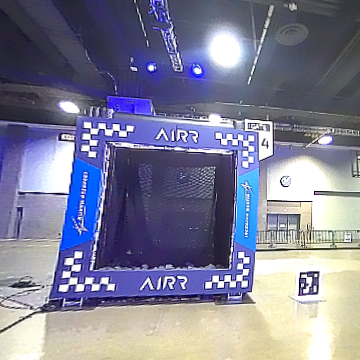

In [16]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

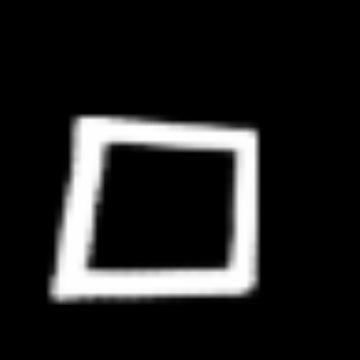

In [17]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [18]:
print(dataset_test_0[0][1]['image_id'])

tensor([0])


In [19]:
print(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## 4. ROC Curve

In [25]:
import ROC
import cv2
import matplotlib.pyplot as plt

# Change ONLY the following line:
Values = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()

# make it a flat list of values, in the right order:
Values = Values.flatten();

masks = [cv2.imread(filename, flags=cv2.IMREAD_GRAYSCALE) \
                                 for filename in mask_filenames]
classes = masks[280]
classes[classes > 0] = 1
classes = classes.flatten()

# get the ROC curve:
TP, FP = ROC.get_ROC_curve(Values, classes)

Text(0.5, 0, 'FP')

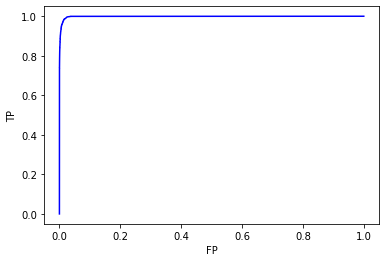

In [26]:
# plot the ROC curve:
plt.figure()
plt.plot(FP, TP, 'b')
plt.ylabel('TP')
plt.xlabel('FP')